In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers, regularizers

In [2]:
train=pd.read_csv('SQLIV3_cleaned2.csv')
test=pd.read_csv('sqliv2_utf8.csv')


In [3]:
train.Label.value_counts()


0    19268
1    11346
Name: Label, dtype: int64

In [4]:
hidden_units1=512
hidden_units2=256
hidden_units3=128
learning_rate=0.01
hidden_layer_act='relu'
output_layer_act='sigmoid'
no_epochs=27

In [5]:
model = Sequential()


In [6]:

model.add(Dense(hidden_units1, input_dim=3000, activation=hidden_layer_act))
model.add(Dense(hidden_units2, activation=hidden_layer_act))
model.add(Dense(hidden_units3, activation=hidden_layer_act))
model.add(Dense(1, activation=output_layer_act))  # Couche de sortie

In [7]:
sgd=optimizers.SGD(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy',optimizer=sgd, metrics=['accuracy'])

In [8]:
train.head()

,Sentence,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1


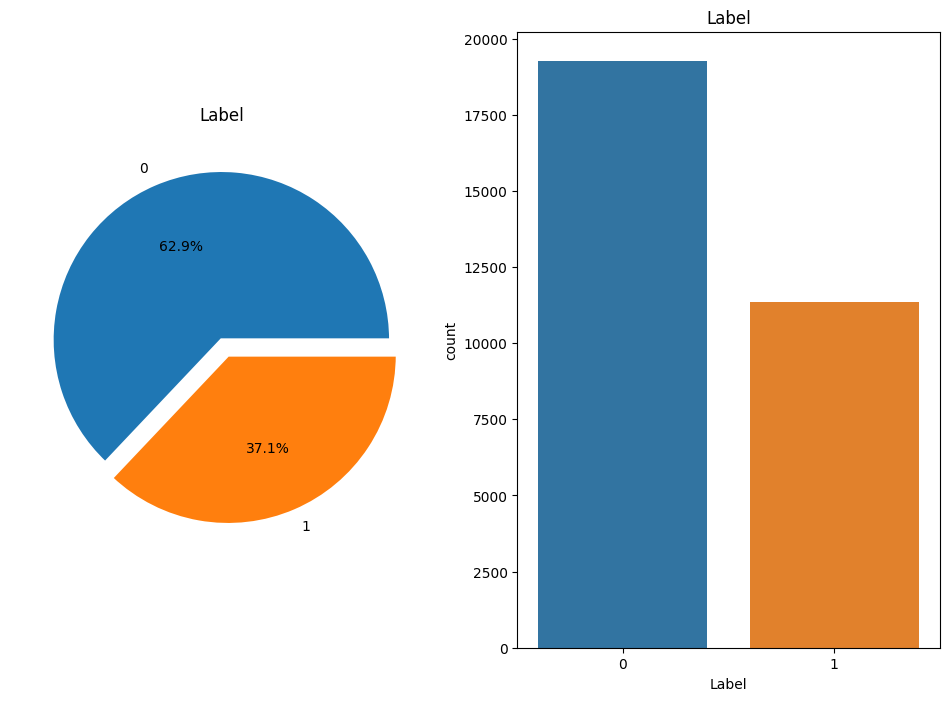

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
f, ax = plt.subplots(1, 2, figsize=(12, 8))
colors = list(mcolors.TABLEAU_COLORS.values())
train['Label'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], wedgeprops={'edgecolor': 'white', 'linewidth': 2, 'antialiased': True}, colors=colors)

ax[0].set_title('Label')
ax[0].set_ylabel('')
sns.countplot(x='Label', data=train, ax=ax[1], palette=colors)
ax[1].set_title('Label')
plt.show()

In [10]:
train_x = train['Sentence'].values
train_y = train['Label'].values

##test_x = test['Sentence'].values
##test_y = test['Label'].values

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=3000)
train_x = vectorizer.fit_transform(train_x).toarray()



In [12]:
history = model.fit(train_x, train_y, epochs=no_epochs, batch_size=32, verbose=2, validation_split=0.2)


Epoch 1/27
766/766 - 20s - loss: 0.6599 - accuracy: 0.6155 - val_loss: 0.6192 - val_accuracy: 1.0000
Epoch 2/27
766/766 - 23s - loss: 0.5054 - accuracy: 0.8867 - val_loss: 0.4402 - val_accuracy: 0.9600
Epoch 3/27
766/766 - 22s - loss: 0.2201 - accuracy: 0.9415 - val_loss: 0.1776 - val_accuracy: 0.9796
Epoch 4/27
766/766 - 20s - loss: 0.1247 - accuracy: 0.9575 - val_loss: 0.1081 - val_accuracy: 0.9815
Epoch 5/27
766/766 - 18s - loss: 0.0938 - accuracy: 0.9656 - val_loss: 0.1163 - val_accuracy: 0.9698
Epoch 6/27
766/766 - 17s - loss: 0.0759 - accuracy: 0.9749 - val_loss: 0.0670 - val_accuracy: 0.9802
Epoch 7/27
766/766 - 16s - loss: 0.0647 - accuracy: 0.9826 - val_loss: 0.0562 - val_accuracy: 0.9819
Epoch 8/27
766/766 - 14s - loss: 0.0566 - accuracy: 0.9868 - val_loss: 0.0448 - val_accuracy: 0.9835
Epoch 9/27
766/766 - 15s - loss: 0.0510 - accuracy: 0.9895 - val_loss: 0.0411 - val_accuracy: 0.9840
Epoch 10/27
766/766 - 16s - loss: 0.0467 - accuracy: 0.9909 - val_loss: 0.0288 - val_accura

In [13]:
# Affichage de la loss et accuracy après l'entraînement
print("Final Training Loss:", history.history['loss'][-1])
print("Final Training Accuracy:", history.history['accuracy'][-1])



Final Training Loss: 0.03034457378089428
Final Training Accuracy: 0.9944877624511719


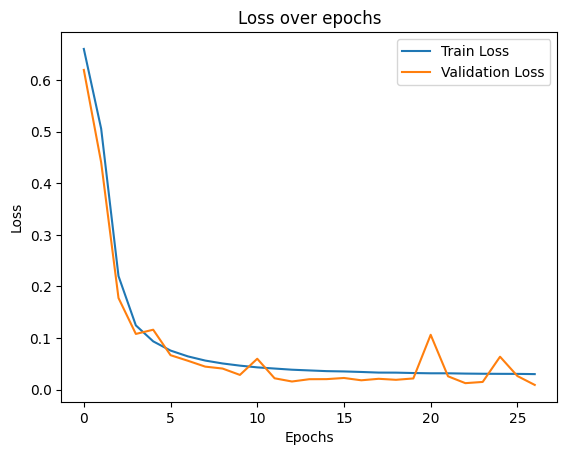

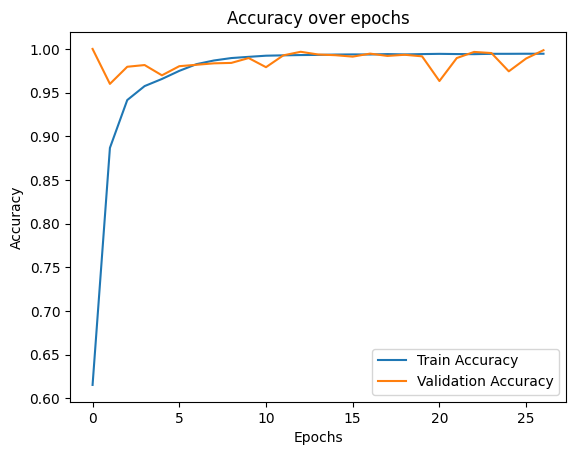

In [14]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
test_x = test['Sentence'].values
test_y = test['Label'].values
print(test.isnull().sum())


Sentence    3
Label       0
dtype: int64


In [16]:
test = test.dropna(subset=['Sentence'])



In [17]:
# Filtrer les lignes où Label == 1
filtered = test[test['Label'] == 1]

# Supprimer les doublons en gardant la première occurrence
filtered = filtered.drop_duplicates(subset='Sentence', keep='first')

# Récupérer les 1000 exemples dans test_x et test_y
test_x = filtered['Sentence'].values
test_y = filtered['Label'].values

test_x = vectorizer.transform(test_x).toarray()


In [18]:
predictions = model.predict(test_x)


In [19]:
# Convertir les probabilités en classes binaires
predicted_classes = (predictions >= 0.5).astype(int)

# Afficher les 20 premières prédictions
print(predicted_classes.flatten())


[1 1 0 ... 1 1 1]


In [20]:
# Compter le nombre de prédictions égales à 1
nombre_de_sql_injections = (predicted_classes == 1).sum()

print(f"Nombre de requêtes détectées comme SQL injection : {nombre_de_sql_injections}")


Nombre de requêtes détectées comme SQL injection : 11251


In [21]:
test.Label.value_counts()


0    22304
1    11453
Name: Label, dtype: int64

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


print(f"Nombre de requêtes détectées comme SQL injection : {nombre_de_sql_injections} / {len(test_x)}")
print(f"Accuracy après test avec le dataset filtré (SQL injections) : {accuracy_score(test_y, predicted_classes) * 100:.2f}%")
print(f"Precision : {precision_score(test_y, predicted_classes, zero_division=0) * 100:.2f}%")
print(f"Recall : {recall_score(test_y, predicted_classes, zero_division=0) * 100:.2f}%")
print(f"F1 Score : {f1_score(test_y, predicted_classes, zero_division=0) * 100:.2f}%")


Nombre de requêtes détectées comme SQL injection : 11251 / 11424
Accuracy après test avec le dataset filtré (SQL injections) : 98.49%
Precision : 100.00%
Recall : 98.49%
F1 Score : 99.24%


In [23]:
# Filtrer les lignes où Label == 1
filtered2 = test[test['Label'] == 0]
filtered2 = filtered.drop_duplicates(subset='Sentence', keep='first')

# Récupérer les 1000 exemples dans test_x et test_y
test_x2 = filtered2['Sentence'].values
test_y2 = filtered2['Label'].values


test_x2 = vectorizer.transform(test_x2).toarray()

In [24]:
predictions2 = model.predict(test_x2)


In [25]:
# Convertir les probabilités en classes binaires
predicted_classes2 = (predictions2 >= 0.5).astype(int)

# Afficher les 20 premières prédictions
print(predicted_classes2.flatten())


[1 1 0 ... 1 1 1]


In [26]:
# Compter le nombre de prédictions égales à 1
nombre_de_non_sql_injections = (predicted_classes2 == 0).sum()

print(f"Nombre de requêtes non détectées comme SQL injection : {nombre_de_non_sql_injections}")


Nombre de requêtes non détectées comme SQL injection : 173


In [27]:
test.Label.value_counts()


0    22304
1    11453
Name: Label, dtype: int64

In [28]:
print(f"accuracy apres testé avec le deuxiéme datset avec les non sql injection est ={nombre_de_non_sql_injections/len(test_x2)} ")

accuracy apres testé avec le deuxiéme datset avec les non sql injection est =0.015143557422969188 


In [29]:




print(f"Nombre de requêtes détectées comme NON SQL injection : {nombre_de_non_sql_injections} / {len(test_x2)}")

# 8. Afficher l’accuracy (et éventuellement d'autres métriques)
print(f"Accuracy après test avec le dataset des NON-SQL : {accuracy_score(test_y2, predicted_classes2) * 100:.2f}%")
print(f"Precision : {precision_score(test_y2, predicted_classes2, zero_division=0, pos_label=0) * 100:.2f}%")
print(f"Recall : {recall_score(test_y2, predicted_classes2, zero_division=0, pos_label=0) * 100:.2f}%")
print(f"F1 Score : {f1_score(test_y2, predicted_classes2, zero_division=0, pos_label=0) * 100:.2f}%")


Nombre de requêtes détectées comme NON SQL injection : 173 / 11424
Accuracy après test avec le dataset des NON-SQL : 98.49%
Precision : 0.00%
Recall : 0.00%
F1 Score : 0.00%
